# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import cv2
import csv
import math
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool 
%matplotlib inline

from utils import *

In [2]:
training_file = "../../data/traffic-signs-data/train.p"
validation_file= "../../data/traffic-signs-data/valid.p"
testing_file = "../../data/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = x_train.shape[0]

n_validation = x_valid.shape[0]

n_test = x_test.shape[0]

image_shape = x_train.shape[1:]

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

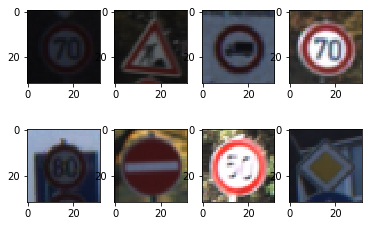

In [4]:
for i in range(8):
    ix = i + 1
    r = np.random.randint(1, high=n_train)
    a = plt.subplot(2, 4, ix)
    img = x_train[r]
    a.imshow(img)
    
#plt.savefig("sample_original_images.jpg")

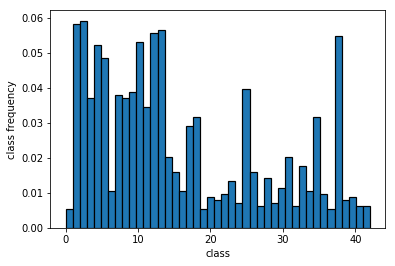

In [5]:
plt.hist(y_train, bins=43, edgecolor='black', linewidth=1.2, normed=True)
plt.ylabel("class frequency")
plt.xlabel("class")
#plt.savefig("visualization.jpg")
plt.show()

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale.)

In [6]:
img = x_train[0]

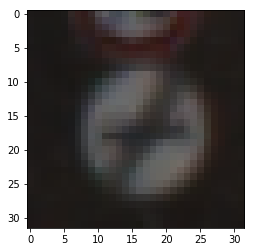

In [7]:
plt.imshow(img)

### preprocess functions

In [8]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    
def hsvscale(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv

def yuvscale(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return hsv


def min_max_scaling(x, a=0, b=1):

	x_min = x.min()
	x_max = x.max()
	x_n = a + ((x - x_min)/(x_max - x_min)) * (b - a)
	return x_n

def scaling(x):
    
    x = x.astype(float)
    x_scaled = (x - 128) / 128
    return x_scaled

def preprocess(x, flag):
    
    # attention: original dataset type unsigned int8 0-255
    
    if flag == "only_gray":
        gray = np.array([ grayscale(i) for i in x ])
        n, m, r = gray.shape
        x_train = gray.reshape((n, m, r, 1))
    
    elif flag == "gray":
        
        gray = np.array([ grayscale(i) for i in x ])
        x_train = scaling(gray)
        
        n, m, r = x_train.shape
        x_train = x_train.reshape((n, m, r, 1))
    
    elif flag == "yuv":
        yuv = np.array([ yuvscale(i) for i in x ])
        x_train = scaling(yuv)
        
    elif flag == "hsv":
        hsv = np.array([ hsvscale(i) for i in x ])
        x_train = scaling(hsv)
        
    elif flag == "scale":
        x = x.astype(float)
        x_train = scaling(x)
        
        if len(x_train.shape) == 3:
            n, m, r = x_train.shape
            x_train = x_train.reshape((n, m, r, 1))
            
    
    return x_train

def preprocess_all(x_train, x_valid, x_test, t="gray"):

    X_train = preprocess(x_train, flag = t)
    X_valid = preprocess(x_valid, flag = t)
    X_test  = preprocess(x_test, flag = t)
    
    return X_train, X_valid, X_test

In [9]:
distro = labels_distro(y_train)   ### class frequency

In [10]:
distro

{0: 0.5172562429954883,
 1: 5.689818672950373,
 2: 5.776028046782954,
 3: 3.620793700968419,
 4: 5.086353056122302,
 5: 4.741515560791977,
 6: 1.0345124859909767,
 7: 3.707003074801,
 8: 3.620793700968419,
 9: 3.7932124486335814,
 10: 5.172562429954883,
 11: 3.3621655794706746,
 12: 5.4311905514526275,
 13: 5.5173999252852095,
 14: 1.982815598149372,
 15: 1.5517687289864652,
 16: 1.0345124859909767,
 17: 2.8449093364751863,
 18: 3.1035374579729305,
 19: 0.5172562429954883,
 20: 0.8620937383258139,
 21: 0.7758843644932326,
 22: 0.9483031121583954,
 23: 1.2931406074887208,
 24: 0.6896749906606512,
 25: 3.879421822466163,
 26: 1.5517687289864652,
 27: 0.6034656168280698,
 28: 1.3793499813213024,
 29: 0.6896749906606512,
 30: 1.1207218598235582,
 31: 1.982815598149372,
 32: 0.6034656168280698,
 33: 1.7213138308572085,
 34: 1.0345124859909767,
 35: 3.1035374579729305,
 36: 0.9483031121583954,
 37: 0.5172562429954883,
 38: 5.344981177620046,
 39: 0.7758843644932326,
 40: 0.8620937383258139,


### preprocess

In [11]:
X_train, X_valid, X_test = preprocess_all(x_train, x_valid, x_test, "gray")

### parallel computation to generate data augmentation

results = parallel(data, worker)

X_train, y_train = concatenate(results, X_train, y_train)

### data augmentation

with open("new_train.pickle", "rb") as f:
    
    new_train = pickle.load(f)

X_train, y_train = new_train['features'], new_train['labels']

X_train, X_valid, X_test = preprocess_all(X_train, X_valid, X_test, "scale")

X_train.shape

labels_distro(y_train)

plt.hist(y_train, bins=43, edgecolor='black', linewidth=1.2)
plt.show()

### Model Parameters

In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten, xavier_initializer

def parameters():
    
    c = X_train.shape[-1]
    filter_size = [[5, 5, c, 6], [5, 5, 6, 32]]
    layer_size = [[800, 400], [400, 200], [200, n_classes]]

    W = {}
    # conv
    W1 = tf.get_variable(name="W1", shape=filter_size[0], initializer=xavier_initializer(seed=1))
    b1 = tf.Variable(tf.zeros([1, filter_size[0][-1]]), name="b1")
    #b1 = tf.get_variable(name="b1", shape=[1, filter_size[0][-1]],initializer=tf.zeros_initializer())
    
    # conv
    W2 = tf.get_variable(name="W2", shape=filter_size[1], initializer=xavier_initializer(seed=1))
    b2 = tf.Variable(tf.zeros([1, filter_size[1][-1]]), name="b2")
    # full
    W3 = tf.get_variable(name="W3", shape=layer_size[0], initializer=xavier_initializer(seed=1))
    b3 = tf.Variable(tf.zeros([1, layer_size[0][-1]]), name="b3")
    # full
    W4 = tf.get_variable(name="W4", shape=layer_size[1], initializer=xavier_initializer(seed=1))
    b4 = tf.Variable(tf.zeros([1, layer_size[1][-1]]), name="b4")
    
    # full
    W5 = tf.get_variable(name="W5", shape=layer_size[2], initializer=xavier_initializer(seed=1))
    b5 = tf.Variable(tf.zeros([1, layer_size[2][-1]]), name="b5")
    
    W = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3, "W4": W4, "b4": b4, "W5": W5, "b5": b5}

    return W

### hyperparameters

In [13]:
height, width, channels =  X_train[0].shape

drop_prob = 0.8
learning_rate = 0.001
BATCH_SIZE = 64
EPOCHS = 20
initial_learning_rate = 0.001
step_until_decay = X_train.shape[0]
decay_rate = 0.99

### Model Architecture

In [14]:
def LeNet(x, W, drop_prob):    
    
    # x : [batch, height, width, channels]
    
    W1, W2, W3, W4, W5 = W["W1"], W["W2"], W["W3"], W["W4"], W["W5"]
    b1, b2, b3, b4, b5 = W["b1"], W["b2"], W["b3"], W["b4"], W["b5"]
    
    s1 = [1, 1, 1, 1]
    s2 = [1, 2, 2, 1]
    v = "VALID"
    
    # filter -----> [filter_height, filter_width, in_channels, out_channels]
    # at every layer we create  out_channels filters of dimension (patch_size * patch_size * in_channels)
    
    # to compute the size of the next conv layer 
    # W = (W - F + 2P)/S + 1
    # W width(oe height)
    # F filter width
    # P padding size
    # S stride
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv = tf.nn.conv2d(x, W1, strides = s1, padding=v)
    # Activation.
    conv = tf.nn.relu(tf.add(conv, b1))
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv = tf.nn.max_pool(conv, ksize=s2, strides=s2, padding=v)

    # Layer 2: Convolutional. Output = 10x10x32.
    conv = tf.nn.conv2d(conv, W2, strides = s1, padding=v)
    # Activation.
    conv = tf.nn.relu(tf.add(conv, b2))
    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv = tf.nn.max_pool(conv, ksize=s2, strides=s2, padding=v)

    # Flatten. Input = 5x5x18. Output = 800.
    flat = flatten(conv)
    
    # Layer 3: Fully Connected. Input = 800. Output = 400.
    layer = tf.add(tf.matmul(flat, W3), b3)
    # Activation.
    layer = tf.nn.relu(layer)
    # Regularization
    layer = tf.nn.dropout(layer, keep_prob=drop_prob)

    # Layer 4: Fully Connected. Input = 400. Output = 200.
    layer = tf.add(tf.matmul(layer, W4), b4)
    # Activation.
    layer = tf.nn.relu(layer)
    # Regularization
    layer = tf.nn.dropout(layer, keep_prob=drop_prob)

    # Layer 5: Fully Connected. Input = 200. Output = n_classes.
    logits = tf.add(tf.matmul(layer, W5), b5, name="logits")
    
    return logits

### build computational static graph

In [15]:
graph = tf.Graph()

with graph.as_default():
    
    x = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="x")
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    y_one_hot = tf.one_hot(y, n_classes)
    drop = tf.placeholder(tf.float32, shape=(), name="drop")
    
    W = parameters()
    logits = LeNet(x, W, drop_prob)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_one_hot, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, step_until_decay, decay_rate)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    trainer = optimizer.minimize(loss, global_step=global_step)
    
    y_pred = tf.argmax(logits, axis=1, name="y_pred")
    y_true = tf.argmax(y_one_hot, axis=1, name="y_true")
    
    prediction = tf.equal(y_pred, y_true)
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32), name="accuracy")
    
    saver = tf.train.Saver()

### Train, Validate and Test the Model

In [16]:
def compute_batch(X_train, y_train, ix):
    
    x_batch = X_train[ix:(ix+BATCH_SIZE)]
    y_batch = y_train[ix:(ix+BATCH_SIZE)]
    
    return x_batch, y_batch

def evaluate(X_val, y_val, sess, drop_prob=1.0):
    
    N = len(X_val)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for ix in range(0, N, BATCH_SIZE):
        x_batch, y_batch = compute_batch(X_val, y_val, ix)
        
        feed_dict = {x: x_batch, y: y_batch, drop: drop_prob}
        acc_batch = sess.run(accuracy, feed_dict=feed_dict)
        total_accuracy += acc_batch
        
    return total_accuracy * (BATCH_SIZE / N)

### Run model

In [17]:
losses = []
acc_train = []
acc_val = []

with tf.Session(graph=graph) as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    N = len(X_train)
    
    try:
        for epoch in range(EPOCHS):

            X_train, y_train = shuffle(X_train, y_train)
            for ix in range(0, N, BATCH_SIZE): 

                x_batch, y_batch = compute_batch(X_train, y_train, ix)
                feed_dict = {x: x_batch, y: y_batch, drop: drop_prob}

                _, l = sess.run([trainer, loss], feed_dict=feed_dict)
                losses.append(l)

            print("-----------------------------------------------")
            print("epoch: ", epoch + 1)
            print("loss: ", l)
            train_accuracy = evaluate(X_train[:1920], y_train[:1920], sess)
            validation_accuracy = evaluate(X_valid, y_valid, sess)
            print("train accuracy: ", train_accuracy)
            acc_train.append(train_accuracy)
            print("validation accuracy: ", validation_accuracy)
            acc_val.append(validation_accuracy)
            print("-----------------------------------------------")
            
            if epoch % 10 == 0:
                saver.save( sess, "./model/lenet", global_step=global_step )
                
        
        saver.save( sess, "./model/lenet" )
        print("Model saved") 

    except KeyboardInterrupt:
        #saver.save( sess, "./model/lenet", global_step=global_step )
        print("Bye")

-----------------------------------------------
epoch:  1
loss:  0.388747
train accuracy:  0.907291666667
validation accuracy:  0.84101962654
-----------------------------------------------
-----------------------------------------------
epoch:  2
loss:  0.111596
train accuracy:  0.961458333333
validation accuracy:  0.896598639456
-----------------------------------------------
-----------------------------------------------
epoch:  3
loss:  0.193804
train accuracy:  0.9796875
validation accuracy:  0.913605442177
-----------------------------------------------
-----------------------------------------------
epoch:  4
loss:  0.0430372
train accuracy:  0.986979166667
validation accuracy:  0.928524512985
-----------------------------------------------
-----------------------------------------------
epoch:  5
loss:  0.0315345
train accuracy:  0.984895833333
validation accuracy:  0.919931191165
-----------------------------------------------
-----------------------------------------------
e

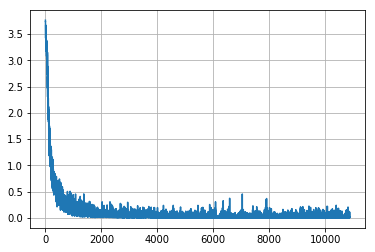

In [18]:
plt.plot(losses)
plt.grid()

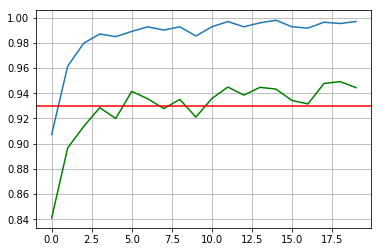

In [19]:
plt.plot(acc_train)
plt.plot(acc_val, color="green")
plt.axhline(0.93, color="red")
plt.grid()

In [20]:
np.mean(acc_val[-10:-1])

0.94108478654749483

In [21]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten, xavier_initializer

In [22]:
X_test = preprocess(x_test, "gray")

In [23]:
new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    
    
    new_saver = tf.train.import_meta_graph('./model/lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    # Now, let's access and create placeholders variables and
    # create feed-dict to feed new data
    x = new_graph.get_tensor_by_name("x:0")
    y = new_graph.get_tensor_by_name("y:0")
    drop = new_graph.get_tensor_by_name("drop:0")
    #y_one_hot = tf.one_hot(y, n_classes) 
    accuracy = new_graph.get_tensor_by_name("accuracy:0")
    y_pred = new_graph.get_tensor_by_name("y_pred:0")
    
    test_accuracy = evaluate(X_test, y_test, sess)
    
    print("test accuracy: ", test_accuracy)

test accuracy:  0.926322608398


---

## Step 3: Test a Model on New Images



In [24]:
def sign_map():
    
    sign_name_map = {} 
    logic = False
    with open('signnames.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if logic:
                sign_name_map[row[0]] = row[1]
            logic = True
    return sign_name_map

In [25]:
sign_name_map = sign_map()

In [26]:
sign_name_map

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '10': 'No passing for vehicles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vehicles',
 '16': 'Vehicles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '2': 'Speed limit (50km/h)',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '3': 'Speed limit (60km/h)',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn right ahead',
 '34': 'Turn left ahead',
 '35': 'Ahead only',
 '36': 'Go straight or right',
 '37': 'Go straight or left',
 '38': 'Keep right',
 '39': 'Keep left',
 '4': 'Speed lim

### Load and Output the Images

In [27]:
import os
import cv2

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [29]:
path = "./images/"
im = os.listdir(path)

images = np.zeros((len(im), 32, 32, 3), dtype=np.uint8)
labels = np.zeros(len(images), dtype=np.uint8)
for i in range(len(im)):
    
    url = path + im[i]
    img = mpimg.imread(url)
    img = cv2.resize(img, (32, 32)) 
    images[i, :, :, :] = img
    
    labels[i] = int(im[i].split(".")[0])
    
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

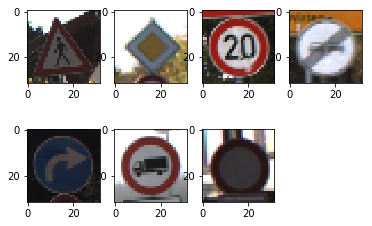

In [30]:
for i in range(len(images)):
    
    ix = i + 1
    a = plt.subplot(2,4,ix)
    img = images[i]
    a.imshow(img)

In [31]:
X_batch = preprocess(images, "gray")

In [32]:
y_batch = labels[:]

### Predict the Sign Type for Each Image

In [33]:
new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    
    
    new_saver = tf.train.import_meta_graph('./model/lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    # Now, let's access and create placeholders variables and
    # create feed-dict to feed new data
    x = new_graph.get_tensor_by_name("x:0")
    y = new_graph.get_tensor_by_name("y:0")
    #y_one_hot = tf.one_hot(y, n_classes) 
    y_pred = new_graph.get_tensor_by_name("y_pred:0")
    
    prediction = sess.run(y_pred, feed_dict={x:X_batch})
    
    print(prediction)

[27 12  0 41 33 16 15]


In [34]:
(y_batch == prediction).mean()

1.0

### Analyze Performance

In [35]:
accuracy = (y_batch == prediction).mean()

print(str(accuracy*100) + " %")

100.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [38]:
#new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    
    new_saver = tf.train.import_meta_graph('./model/lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    x = new_graph.get_tensor_by_name("x:0")
    y = new_graph.get_tensor_by_name("y:0") 
    
    logits = new_graph.get_tensor_by_name("logits:0")
    y_classes = tf.nn.softmax(logits)
    
    y_classes = sess.run(y_classes, feed_dict={x:X_batch})
    y_top5 = sess.run(tf.nn.top_k(y_classes, k=5))

In [41]:
sign_name_map

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '10': 'No passing for vehicles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vehicles',
 '16': 'Vehicles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '2': 'Speed limit (50km/h)',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '3': 'Speed limit (60km/h)',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn right ahead',
 '34': 'Turn left ahead',
 '35': 'Ahead only',
 '36': 'Go straight or right',
 '37': 'Go straight or left',
 '38': 'Keep right',
 '39': 'Keep left',
 '4': 'Speed lim

In [40]:
for i in range(len(y_batch)):
    
    print("true class: ", y_batch[i])
    print("probs top 5 classes: ", y_top5[0][i])
    print("top 5 classes: ", y_top5[1][i])
    print()

true class:  27
probs top 5 classes:  [  9.99202788e-01   7.83480296e-04   8.86880025e-06   2.18602531e-06
   9.28980967e-07]
top 5 classes:  [27 24 11 21 28]

true class:  12
probs top 5 classes:  [  1.00000000e+00   2.79023549e-13   5.12262487e-15   8.98146727e-16
   6.07002537e-17]
top 5 classes:  [12 35 38  9 32]

true class:  0
probs top 5 classes:  [  1.00000000e+00   1.07493318e-14   8.98159922e-17   5.29037009e-18
   1.73922313e-18]
top 5 classes:  [ 0  1 38  8  4]

true class:  41
probs top 5 classes:  [  1.00000000e+00   2.58672084e-09   2.90185757e-12   3.56318138e-13
   9.85398659e-15]
top 5 classes:  [41 42 20  9 17]

true class:  33
probs top 5 classes:  [  9.99901652e-01   9.61137484e-05   1.76975391e-06   2.14867782e-07
   6.73340068e-08]
top 5 classes:  [33 14 15 39  9]

true class:  16
probs top 5 classes:  [  1.00000000e+00   2.74473615e-16   2.35181940e-17   4.23684722e-18
   1.35862761e-18]
top 5 classes:  [16 10  9  7  5]

true class:  15
probs top 5 classes:  [  

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    
    
    new_saver = tf.train.import_meta_graph('./model/lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    
    image_input = X_train[1000]
    x = tf.placeholder(tf.float32, shape=[32, 32, 1])
    
    tf_activation = new_graph.get_tensor_by_name("W2:0")
    
    outputFeatureMap(image_input, tf_activation)